In [1]:
%matplotlib inline

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization # how to import text vectorization in tf 2.3.0
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
import gensim
from gensim.models import Word2Vec
from keras.models import Model
from tensorflow.keras.layers import Embedding,Input,Dropout, Flatten, LSTM, Bidirectional, \
    Conv1D, MaxPool1D, Dense, Attention
from tensorflow.keras.models import Sequential

from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping
from keras.preprocessing.text import Tokenizer


import mlflow
plt.style.use('seaborn')

## Models hyperparamters version 2

* maximum length of the sequences - we will not use the actual maximum length of the sequences as very few songs have 800 words in them. If we choose a maximum length equal to 300, we will cover 94% of the lyrics' actual length, if we choose 250 - we will cover 90%. We can try with 300, if we have a problem with the vanishing gradient - we can decrease it to 250 or even 200 (85%)

* maximum vocabulary size (word-based vocabulary) -  The set of unique words used in the text corpus is ~ 50 000. Given the fact that we work with lyrics of songs, even though we selected only English lyrics there is a high probability that there are some words left from Spanish ( typical for pop songs), some typical slang for artists, and other peculiarities. Thus we will use the maximum size of vocabulary 10 000 ( if it is too big, we can drop it to 5000) and keep only the most common words.


* BATCH_SIZE = 16 
* MAX_VOCABULARY_SIZE = 10000 
* MAX_OUTPUT_LENGTH = 300
* EMBEDDING_DIMENSIONS = 100 #loaded GloVe trained  with 100d
* LEARNING_RATE = 1e-6

In [190]:
TRAIN_BASE_DIR = r"C:\Users\PC\Desktop\NN\Text calssification\train"
TEST_BASE_DIR = r"C:\Users\PC\Desktop\NN\Text calssification\test"
logs = r"C:\Users\PC\Desktop\NN\Text calssification\logs"
check_point_base = r"C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base"
check_point_opt = r"C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt"
check_point_bi = r"C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_bi"
check_point_cnn = r"C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn"
check_point_cnn_2 = r"C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn_2"

N_CLASSES = 4

BATCH_SIZE = 16 # 8
MAX_VOCABULARY_SIZE = 10000 # change to 5000 if too big
MAX_OUTPUT_LENGTH = 300 # 300
EMBEDDING_DIMENSIONS = 100 #loaded GloVe trained  with 100d
LEARNING_RATE = 1e-6
Seed = 42

In [4]:

train_dataset = tf.keras.utils.text_dataset_from_directory(TRAIN_BASE_DIR,batch_size = BATCH_SIZE, validation_split=0.1,
    subset='training', seed = Seed)
   
   

Found 65048 files belonging to 4 classes.
Using 58544 files for training.


Found 65048 files belonging to 4 classes.
Using 58544 files for training.

In [5]:
print(train_dataset.cardinality().numpy())

3659


In [6]:
val_dataset = tf.keras.utils.text_dataset_from_directory(
    TRAIN_BASE_DIR, batch_size=BATCH_SIZE, validation_split=0.1,
    subset='validation', seed=Seed)

Found 65048 files belonging to 4 classes.
Using 6504 files for validation.


In [7]:
test_dataset = tf.keras.utils.text_dataset_from_directory(TEST_BASE_DIR,batch_size = BATCH_SIZE, seed = Seed)

Found 4000 files belonging to 4 classes.


In [8]:
### check the labesl
list(enumerate(train_dataset.class_names)), list(enumerate(val_dataset.class_names))

([(0, 'Jazz'), (1, 'Metal'), (2, 'Pop'), (3, 'Rock')],
 [(0, 'Jazz'), (1, 'Metal'), (2, 'Pop'), (3, 'Rock')])

In [9]:
list(enumerate(train_dataset.class_names))[1]

(1, 'Metal')

.shape method in keras gives the lenght of a sequence

## Vectorizing the text

This layer has basic options for managing text in a Keras model. It transforms a batch of strings (one sample = one string) into either a list of token indices (one sample = 1D tensor of integer token indices) or a dense representation (one sample = 1D tensor of float values representing data about the sample's tokens).

In [10]:
vectorize_layer = TextVectorization(
    max_tokens = MAX_VOCABULARY_SIZE, 
    output_sequence_length=MAX_OUTPUT_LENGTH)

In [11]:
text_ds = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [12]:
### 76952 vocabulary size without limiting the vocabulary size to max size

In [13]:
#text_ds

In [14]:
vectorize_layer.vocabulary_size()

10000

In [15]:
## 1 is unkown

In [16]:
#vectorize_layer(["something nigga money where love queen king boy girl"])

In [17]:
### test
vectorize_layer.get_vocabulary()[4000:]


['rang',
 'liberate',
 'imitation',
 'harvest',
 'frail',
 'eminem',
 'ditch',
 'crucify',
 'carter',
 'carol',
 'canvas',
 'brief',
 'yelling',
 'village',
 'stunna',
 'slut',
 'rocker',
 'relation',
 'oooo',
 'moonlit',
 'max',
 'loco',
 'league',
 'kelly',
 'incomplete',
 'grinding',
 'donna',
 'diggin',
 'decline',
 'coulda',
 'argue',
 'tuck',
 'spiral',
 'raped',
 'poster',
 'pitter',
 'marie',
 'lucifer',
 'lettin',
 'howling',
 'gyal',
 'farmer',
 'crunk',
 'countin',
 'assume',
 'aisle',
 'actor',
 'yow',
 'western',
 'upstairs',
 'twerk',
 'tipsy',
 'tic',
 'suffocate',
 'stash',
 'stairway',
 'sideways',
 'ruler',
 'rooftop',
 'retreat',
 'permanent',
 'nurse',
 'jury',
 'fu',
 'finna',
 'dreamy',
 'declare',
 'daze',
 'collapse',
 'boyz',
 'asshole',
 'worldwide',
 'wage',
 'vibration',
 'sweetness',
 'strut',
 'snatch',
 'rail',
 'purse',
 'nameless',
 'mysterious',
 'melancholy',
 'meanwhile',
 'laura',
 'jo',
 'hustlin',
 'feature',
 'coin',
 'blondie',
 'beyonce',
 'rom

In [18]:
### test 
#output = vectorize_layer([["the cat sat on the mat"]])
#output.numpy()[0, :11]


In [139]:
# Here's a dict mapping words to their indices:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
len(voc)

10000

In [20]:
list(word_index.keys())[:20]

['',
 '[UNK]',
 'im',
 'love',
 'know',
 'dont',
 'like',
 'oh',
 'get',
 'got',
 'go',
 'one',
 'time',
 'youre',
 'never',
 'see',
 'let',
 'come',
 'cant',
 'baby']

In [21]:
tf.keras.backend.clear_session()

### Load Pretrained Glove Word Embedding

#Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.


GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.


The GloVe model is trained on the non-zero entries of a global word-word co-occurrence matrix, which tabulates how frequently words co-occur with one another in a given corpus. Populating this matrix requires a single pass through the entire corpus to collect the statistics. For large corpora, this pass can be computationally expensive, but it is a one-time up-front cost. Subsequent training iterations are much faster because the number of non-zero matrix entries is typically much smaller than the total number of words in the corpus.

In [159]:
vectorize_layer.vocabulary_size()

10000

In [23]:
path_glove = (r'C:\Users\PC\Desktop\NN\NN Project\glove\glove.6B.100d.txt')

In [24]:
embeddings_index = {}
f = open(path_glove,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [25]:
#embeddings_index

#### Creating a weight matrix for words in training docs

In [26]:
### note to self 

#index 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens.
num_tokens = len(voc) + 2
embedding_dim = EMBEDDING_DIMENSIONS
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9679 words (321 misses)


In [27]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41711   , -0.10176   ,  0.058147  , ..., -0.29444   ,
        -0.039114  ,  0.39534   ],
       ...,
       [ 0.63734001, -0.086567  ,  0.61628997, ..., -0.22788   ,
        -0.13654999,  0.01734   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Base LSTM Model

In [142]:
tf.keras.backend.clear_session()
model_name = "base lstm model"
checkpointer = ModelCheckpoint(filepath =check_point_base,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [144]:
lstm_base_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  LSTM(128),
  Dense(N_CLASSES,activation = softmax)])

lstm_base_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [145]:
lstm_base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 300, 100)          1000200   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1,117,964
Trainable params: 117,764
Non-trainable params: 1,000,200
_________________________________________________________________


In [146]:
lstm_history_base_model = lstm_base_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 10,
          callbacks=[checkpointer, early_stopping])

Epoch 1/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3729 - acc: 0.3166

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


3659/3659 [==============================] - 546s 149ms/step - loss: 1.3729 - acc: 0.3166 - val_loss: 1.3675 - val_acc: 0.3295
Epoch 2/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3582 - acc: 0.3362

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


3659/3659 [==============================] - 523s 143ms/step - loss: 1.3582 - acc: 0.3362 - val_loss: 1.3579 - val_acc: 0.3341
Epoch 3/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3498 - acc: 0.3430

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


3659/3659 [==============================] - 512s 140ms/step - loss: 1.3498 - acc: 0.3430 - val_loss: 1.3530 - val_acc: 0.3429
Epoch 4/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3450 - acc: 0.3106

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


3659/3659 [==============================] - 522s 143ms/step - loss: 1.3450 - acc: 0.3106 - val_loss: 1.3495 - val_acc: 0.2841
Epoch 5/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3400 - acc: 0.2930

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


3659/3659 [==============================] - 518s 142ms/step - loss: 1.3400 - acc: 0.2930 - val_loss: 1.3426 - val_acc: 0.2841
Epoch 6/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3233 - acc: 0.2980

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


3659/3659 [==============================] - 525s 144ms/step - loss: 1.3233 - acc: 0.2980 - val_loss: 1.3246 - val_acc: 0.3163
Epoch 7/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3116 - acc: 0.3497

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


3659/3659 [==============================] - 519s 142ms/step - loss: 1.3116 - acc: 0.3497 - val_loss: 1.3176 - val_acc: 0.3567
Epoch 8/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3057 - acc: 0.3665

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


3659/3659 [==============================] - 518s 141ms/step - loss: 1.3057 - acc: 0.3665 - val_loss: 1.3126 - val_acc: 0.3652
Epoch 9/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3011 - acc: 0.3708

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


3659/3659 [==============================] - 516s 141ms/step - loss: 1.3011 - acc: 0.3708 - val_loss: 1.3084 - val_acc: 0.3676
Epoch 10/10
3659/3659 [==============================] - ETA: 0s - loss: 1.2971 - acc: 0.3730

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_base\assets


3659/3659 [==============================] - 519s 142ms/step - loss: 1.2971 - acc: 0.3730 - val_loss: 1.3042 - val_acc: 0.3685


In [35]:
def plot_loss_accuracy(hist,model):
    fig=plt.figure()
    plt.plot(hist.history['acc'],'r',linewidth=3.0)
    plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title(f'Accuracy Curves : {model}',fontsize=16)
    #fig.savefig('accuracy_lstm.png')
    plt.show()

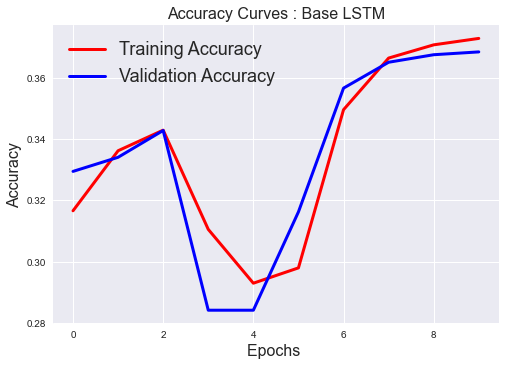

In [147]:
plot_loss_accuracy(lstm_history_base_model, 'Base LSTM')

In [148]:
_,val_acc = lstm_base_model.evaluate(val_dataset)

407/407 [==============================] - 21s 52ms/step - loss: 1.3042 - acc: 0.3685


In [149]:
hist_1 = pd.DataFrame(lstm_history_base_model.history)
hist_1['epoch'] = lstm_history_base_model.epoch

In [150]:
hist_1

,loss,acc,val_loss,val_acc,epoch
0,1.372920,0.316617,1.367484,0.329490,0
1,1.358162,0.336243,1.357880,0.334102,1
2,1.349757,0.342973,1.353011,0.342866,2
3,1.345010,0.310553,1.349515,0.284133,3
4,1.339978,0.292959,1.342627,0.284133,4
5,1.323324,0.297964,1.324612,0.316267,5
6,1.311611,0.349652,1.317608,0.356704,6
7,1.305658,0.366528,1.312590,0.365160,7
8,1.301124,0.370849,1.308378,0.367620,8
9,1.297090,0.372950,1.304216,0.368542,9


In [42]:
lstm_base_model.predict([''' 
It seems you're having some trouble In dealing with these changes Living with these changes (oh no) 
The world is a scary place Now that you've woken up the demon in me 
Why can't you just leave here and die Never stick your hand in my face again bitch
Fuck you
I don't need this shit

''' ])


1/1 [==============================] - 1s 572ms/step


array([[0.72133315, 0.02181528, 0.12567149, 0.13118008]], dtype=float32)

In [43]:
train_dataset.class_names

['Jazz', 'Metal', 'Pop', 'Rock']

## Optimize base LSTM

In [152]:
tf.keras.backend.clear_session()

In [153]:
model_name = "optimized lstm model"
checkpointer_opt = ModelCheckpoint(filepath =check_point_opt,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_opt = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [154]:
lstm_opt_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  LSTM(64,return_sequences=True,dropout=0.2),
  tf.keras.layers.GlobalMaxPooling1D(),
  Dense(64,activation='relu'),
  Dense(N_CLASSES,activation = softmax)])

lstm_opt_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [155]:
lstm_opt_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 100)          1000200   
                                                                 
 lstm (LSTM)                 (None, 300, 64)           42240     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 4)                 2

In [156]:
lstm_history_opt_model = lstm_opt_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 10,
          callbacks=[checkpointer_opt, early_stopping_opt])

Epoch 1/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3828 - acc: 0.2724

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


3659/3659 [==============================] - 371s 101ms/step - loss: 1.3828 - acc: 0.2724 - val_loss: 1.3682 - val_acc: 0.2947
Epoch 2/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3620 - acc: 0.2958

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


3659/3659 [==============================] - 426s 117ms/step - loss: 1.3620 - acc: 0.2958 - val_loss: 1.3578 - val_acc: 0.3063
Epoch 3/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3532 - acc: 0.3159

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


3659/3659 [==============================] - 429s 117ms/step - loss: 1.3532 - acc: 0.3159 - val_loss: 1.3506 - val_acc: 0.3315
Epoch 4/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3463 - acc: 0.3356

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


3659/3659 [==============================] - 438s 120ms/step - loss: 1.3463 - acc: 0.3356 - val_loss: 1.3435 - val_acc: 0.3438
Epoch 5/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3394 - acc: 0.3481

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


3659/3659 [==============================] - 423s 116ms/step - loss: 1.3394 - acc: 0.3481 - val_loss: 1.3365 - val_acc: 0.3532
Epoch 6/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3327 - acc: 0.3546

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


3659/3659 [==============================] - 427s 117ms/step - loss: 1.3327 - acc: 0.3546 - val_loss: 1.3295 - val_acc: 0.3619
Epoch 7/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3260 - acc: 0.3617

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


3659/3659 [==============================] - 425s 116ms/step - loss: 1.3260 - acc: 0.3617 - val_loss: 1.3221 - val_acc: 0.3793
Epoch 8/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3188 - acc: 0.3742

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


3659/3659 [==============================] - 416s 114ms/step - loss: 1.3188 - acc: 0.3742 - val_loss: 1.3142 - val_acc: 0.3950
Epoch 9/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3115 - acc: 0.3840

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


3659/3659 [==============================] - 416s 114ms/step - loss: 1.3115 - acc: 0.3840 - val_loss: 1.3058 - val_acc: 0.4067
Epoch 10/10
3659/3659 [==============================] - ETA: 0s - loss: 1.3038 - acc: 0.3972

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_opt\assets


3659/3659 [==============================] - 421s 115ms/step - loss: 1.3038 - acc: 0.3972 - val_loss: 1.2968 - val_acc: 0.4156


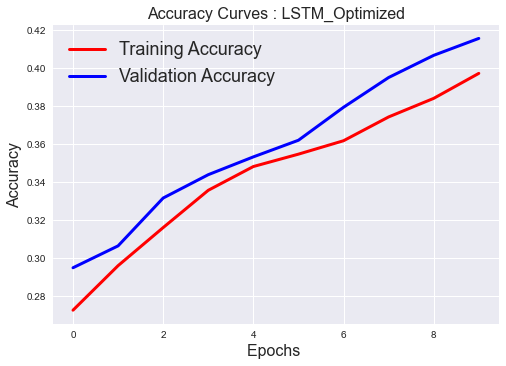

In [157]:
plot_loss_accuracy(lstm_history_opt_model, 'LSTM_Optimized')

In [158]:
_,val_acc = lstm_opt_model.evaluate(val_dataset)

407/407 [==============================] - 17s 41ms/step - loss: 1.2968 - acc: 0.4156


In [160]:
hist_2 = pd.DataFrame(lstm_history_opt_model.history)
hist_2['epoch'] = lstm_history_opt_model.epoch

In [161]:
hist_2

,loss,acc,val_loss,val_acc,epoch
0,1.382796,0.272376,1.368215,0.294742,0
1,1.361954,0.295846,1.357780,0.306273,1
2,1.353200,0.315916,1.350612,0.331488,2
3,1.346282,0.335560,1.343549,0.343788,3
4,1.339414,0.348080,1.336522,0.353167,4
5,1.332666,0.354605,1.329454,0.361931,5
6,1.326007,0.361677,1.322074,0.379305,6
7,1.318779,0.374214,1.314193,0.394988,7
8,1.311515,0.384002,1.305840,0.406673,8
9,1.303776,0.397171,1.296843,0.415590,9


## Bidirectional LSTM

In [168]:
tf.keras.backend.clear_session()

In [169]:
model_name = "bi-directional model"
checkpointer_bi = ModelCheckpoint(filepath =check_point_cnn,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_bi = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [170]:
lstm_bi_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  Bidirectional(LSTM(128)),
  
  Dense(N_CLASSES, activation = softmax)
  ])


lstm_bi_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [171]:
lstm_bi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 100)          1000200   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 1028      
                                                                 
Total params: 1,235,724
Trainable params: 235,524
Non-trainable params: 1,000,200
_________________________________________________________________


In [172]:
lstm_history_bi_model = lstm_bi_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 5,
          callbacks=[checkpointer_bi, early_stopping_bi])

Epoch 1/5
3659/3659 [==============================] - ETA: 0s - loss: 1.3731 - acc: 0.2923

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 1064s 289ms/step - loss: 1.3731 - acc: 0.2923 - val_loss: 1.3576 - val_acc: 0.3160
Epoch 2/5
3659/3659 [==============================] - ETA: 0s - loss: 1.3437 - acc: 0.3231

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 1087s 297ms/step - loss: 1.3437 - acc: 0.3231 - val_loss: 1.3383 - val_acc: 0.3309
Epoch 3/5
3659/3659 [==============================] - ETA: 0s - loss: 1.3260 - acc: 0.3408

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 1221s 334ms/step - loss: 1.3260 - acc: 0.3408 - val_loss: 1.3241 - val_acc: 0.3452
Epoch 4/5
3659/3659 [==============================] - ETA: 0s - loss: 1.3119 - acc: 0.3573

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 1312s 359ms/step - loss: 1.3119 - acc: 0.3573 - val_loss: 1.3101 - val_acc: 0.3687
Epoch 5/5
3659/3659 [==============================] - ETA: 0s - loss: 1.2861 - acc: 0.3915

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 1499s 410ms/step - loss: 1.2861 - acc: 0.3915 - val_loss: 1.2758 - val_acc: 0.4062


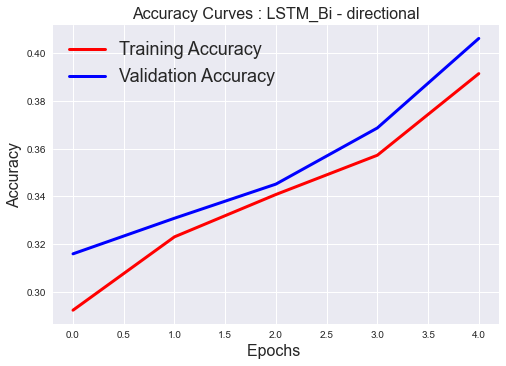

In [173]:
plot_loss_accuracy(lstm_history_bi_model, 'LSTM_Bi - directional')

In [197]:
_,val_acc = lstm_bi_model.evaluate(val_dataset)

407/407 [==============================] - 110s 269ms/step - loss: 1.2758 - acc: 0.4062


In [174]:
hist_3 = pd.DataFrame(lstm_history_bi_model.history)
hist_3['epoch'] = lstm_history_bi_model.epoch

In [175]:
hist_3

,loss,acc,val_loss,val_acc,epoch
0,1.373083,0.292344,1.357639,0.315959,0
1,1.343723,0.323073,1.338346,0.330873,1
2,1.325992,0.340821,1.324068,0.345172,2
3,1.311932,0.357270,1.310093,0.368696,3
4,1.286054,0.391466,1.275828,0.406212,4


## CNN model

In [192]:
tf.keras.backend.clear_session()

In [177]:

checkpointer_cnn = ModelCheckpoint(filepath =check_point_cnn,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_cnn = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [178]:
cnn_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  Conv1D(128,3, padding = 'same', activation= 'relu'),
  MaxPool1D(),
 
  
  Conv1D(128,5, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  
  
  Conv1D(128,5, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  
  
  Flatten(),
  Dense(128, activation = 'relu'),
  Dense(N_CLASSES, activation = softmax)
  ])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [179]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 100)          1000200   
                                                                 
 conv1d (Conv1D)             (None, 300, 128)          38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 128)          0

In [180]:
cnn_history_model = cnn_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 60,
          callbacks=[checkpointer_cnn, early_stopping_cnn])

Epoch 1/60
3659/3659 [==============================] - ETA: 0s - loss: 1.2975 - acc: 0.3645

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 214s 58ms/step - loss: 1.2975 - acc: 0.3645 - val_loss: 1.2789 - val_acc: 0.3921
Epoch 2/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.2581 - acc: 0.4146

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 215s 59ms/step - loss: 1.2581 - acc: 0.4146 - val_loss: 1.2547 - val_acc: 0.4227
Epoch 3/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.2311 - acc: 0.4462

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 194s 53ms/step - loss: 1.2310 - acc: 0.4462 - val_loss: 1.2209 - val_acc: 0.4582
Epoch 4/60
3659/3659 [==============================] - ETA: 0s - loss: 1.1979 - acc: 0.4730

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 194s 53ms/step - loss: 1.1979 - acc: 0.4730 - val_loss: 1.1866 - val_acc: 0.4811
Epoch 5/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.1686 - acc: 0.4865

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 190s 52ms/step - loss: 1.1685 - acc: 0.4865 - val_loss: 1.1593 - val_acc: 0.4985
Epoch 6/60
3659/3659 [==============================] - ETA: 0s - loss: 1.1464 - acc: 0.4962

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 183s 50ms/step - loss: 1.1464 - acc: 0.4962 - val_loss: 1.1406 - val_acc: 0.5074
Epoch 7/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.1302 - acc: 0.5041

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 193s 53ms/step - loss: 1.1302 - acc: 0.5041 - val_loss: 1.1266 - val_acc: 0.5129
Epoch 8/60
3659/3659 [==============================] - ETA: 0s - loss: 1.1174 - acc: 0.5113

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 192s 53ms/step - loss: 1.1174 - acc: 0.5113 - val_loss: 1.1151 - val_acc: 0.5212
Epoch 9/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.1068 - acc: 0.5186

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 190s 52ms/step - loss: 1.1068 - acc: 0.5186 - val_loss: 1.1060 - val_acc: 0.5228
Epoch 10/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0977 - acc: 0.5233

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 190s 52ms/step - loss: 1.0977 - acc: 0.5233 - val_loss: 1.0982 - val_acc: 0.5258
Epoch 11/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0898 - acc: 0.5275

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 184s 50ms/step - loss: 1.0898 - acc: 0.5275 - val_loss: 1.0919 - val_acc: 0.5304
Epoch 12/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0828 - acc: 0.5328

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 190s 52ms/step - loss: 1.0828 - acc: 0.5328 - val_loss: 1.0860 - val_acc: 0.5383
Epoch 13/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0765 - acc: 0.5368

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 190s 52ms/step - loss: 1.0765 - acc: 0.5368 - val_loss: 1.0808 - val_acc: 0.5426
Epoch 14/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0708 - acc: 0.5402

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 190s 52ms/step - loss: 1.0708 - acc: 0.5402 - val_loss: 1.0762 - val_acc: 0.5440
Epoch 15/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0655 - acc: 0.5425

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 190s 52ms/step - loss: 1.0655 - acc: 0.5425 - val_loss: 1.0720 - val_acc: 0.5470
Epoch 16/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0607 - acc: 0.5445

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 189s 52ms/step - loss: 1.0607 - acc: 0.5446 - val_loss: 1.0679 - val_acc: 0.5492
Epoch 17/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0561 - acc: 0.5472

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 188s 51ms/step - loss: 1.0562 - acc: 0.5472 - val_loss: 1.0644 - val_acc: 0.5523
Epoch 18/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0519 - acc: 0.5507

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 188s 51ms/step - loss: 1.0519 - acc: 0.5507 - val_loss: 1.0609 - val_acc: 0.5549
Epoch 19/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0479 - acc: 0.5527

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 189s 52ms/step - loss: 1.0479 - acc: 0.5527 - val_loss: 1.0578 - val_acc: 0.5557
Epoch 20/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0442 - acc: 0.5552

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 189s 52ms/step - loss: 1.0441 - acc: 0.5552 - val_loss: 1.0548 - val_acc: 0.5587
Epoch 21/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0406 - acc: 0.5577

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 189s 52ms/step - loss: 1.0405 - acc: 0.5577 - val_loss: 1.0522 - val_acc: 0.5601
Epoch 22/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0371 - acc: 0.5605

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 190s 52ms/step - loss: 1.0371 - acc: 0.5605 - val_loss: 1.0495 - val_acc: 0.5637
Epoch 23/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0338 - acc: 0.5622

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 182s 50ms/step - loss: 1.0338 - acc: 0.5622 - val_loss: 1.0471 - val_acc: 0.5638
Epoch 24/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0307 - acc: 0.5641

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 188s 51ms/step - loss: 1.0307 - acc: 0.5641 - val_loss: 1.0447 - val_acc: 0.5633
Epoch 25/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0277 - acc: 0.5661

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 189s 52ms/step - loss: 1.0277 - acc: 0.5661 - val_loss: 1.0427 - val_acc: 0.5661
Epoch 26/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0247 - acc: 0.5680

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 189s 52ms/step - loss: 1.0247 - acc: 0.5680 - val_loss: 1.0409 - val_acc: 0.5644
Epoch 27/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0219 - acc: 0.5692

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 189s 52ms/step - loss: 1.0219 - acc: 0.5692 - val_loss: 1.0387 - val_acc: 0.5652
Epoch 28/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0191 - acc: 0.5711

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 188s 51ms/step - loss: 1.0191 - acc: 0.5711 - val_loss: 1.0368 - val_acc: 0.5664
Epoch 29/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0166 - acc: 0.5724

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 188s 51ms/step - loss: 1.0166 - acc: 0.5724 - val_loss: 1.0350 - val_acc: 0.5681
Epoch 30/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0140 - acc: 0.5738

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 189s 52ms/step - loss: 1.0140 - acc: 0.5738 - val_loss: 1.0331 - val_acc: 0.5695
Epoch 31/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0116 - acc: 0.5754

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 189s 52ms/step - loss: 1.0116 - acc: 0.5754 - val_loss: 1.0316 - val_acc: 0.5710
Epoch 32/60
3659/3659 [==============================] - ETA: 0s - loss: 1.0092 - acc: 0.5765

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 188s 51ms/step - loss: 1.0092 - acc: 0.5765 - val_loss: 1.0301 - val_acc: 0.5706
Epoch 33/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0069 - acc: 0.5785

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 188s 51ms/step - loss: 1.0069 - acc: 0.5785 - val_loss: 1.0289 - val_acc: 0.5712
Epoch 34/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0047 - acc: 0.5795

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 185s 50ms/step - loss: 1.0046 - acc: 0.5796 - val_loss: 1.0270 - val_acc: 0.5733
Epoch 35/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0024 - acc: 0.5807

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 173s 47ms/step - loss: 1.0024 - acc: 0.5807 - val_loss: 1.0257 - val_acc: 0.5740
Epoch 36/60
3658/3659 [============================>.] - ETA: 0s - loss: 1.0002 - acc: 0.5818

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 180s 49ms/step - loss: 1.0002 - acc: 0.5817 - val_loss: 1.0246 - val_acc: 0.5750
Epoch 37/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9981 - acc: 0.5828

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 180s 49ms/step - loss: 0.9981 - acc: 0.5828 - val_loss: 1.0231 - val_acc: 0.5747
Epoch 38/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9961 - acc: 0.5837

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 179s 49ms/step - loss: 0.9961 - acc: 0.5837 - val_loss: 1.0218 - val_acc: 0.5760
Epoch 39/60
3658/3659 [============================>.] - ETA: 0s - loss: 0.9939 - acc: 0.5849

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 179s 49ms/step - loss: 0.9939 - acc: 0.5849 - val_loss: 1.0208 - val_acc: 0.5749
Epoch 40/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9920 - acc: 0.5858

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 180s 49ms/step - loss: 0.9920 - acc: 0.5858 - val_loss: 1.0196 - val_acc: 0.5756
Epoch 41/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9901 - acc: 0.5862

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 183s 50ms/step - loss: 0.9901 - acc: 0.5862 - val_loss: 1.0184 - val_acc: 0.5767
Epoch 42/60
3658/3659 [============================>.] - ETA: 0s - loss: 0.9882 - acc: 0.5870

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 184s 50ms/step - loss: 0.9881 - acc: 0.5870 - val_loss: 1.0174 - val_acc: 0.5784
Epoch 43/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9862 - acc: 0.5884

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 176s 48ms/step - loss: 0.9862 - acc: 0.5884 - val_loss: 1.0160 - val_acc: 0.5790
Epoch 44/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9844 - acc: 0.5899

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 183s 50ms/step - loss: 0.9844 - acc: 0.5899 - val_loss: 1.0153 - val_acc: 0.5801
Epoch 45/60
3658/3659 [============================>.] - ETA: 0s - loss: 0.9823 - acc: 0.5911

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 183s 50ms/step - loss: 0.9824 - acc: 0.5911 - val_loss: 1.0143 - val_acc: 0.5796
Epoch 46/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9806 - acc: 0.5920

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 183s 50ms/step - loss: 0.9806 - acc: 0.5920 - val_loss: 1.0132 - val_acc: 0.5812
Epoch 47/60
3658/3659 [============================>.] - ETA: 0s - loss: 0.9788 - acc: 0.5928

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 186s 51ms/step - loss: 0.9788 - acc: 0.5927 - val_loss: 1.0125 - val_acc: 0.5809
Epoch 48/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9771 - acc: 0.5933

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 202s 55ms/step - loss: 0.9771 - acc: 0.5933 - val_loss: 1.0115 - val_acc: 0.5804
Epoch 49/60
3658/3659 [============================>.] - ETA: 0s - loss: 0.9753 - acc: 0.5945

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 193s 53ms/step - loss: 0.9753 - acc: 0.5945 - val_loss: 1.0105 - val_acc: 0.5806
Epoch 50/60
3658/3659 [============================>.] - ETA: 0s - loss: 0.9736 - acc: 0.5956

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 191s 52ms/step - loss: 0.9736 - acc: 0.5956 - val_loss: 1.0095 - val_acc: 0.5815
Epoch 51/60
3658/3659 [============================>.] - ETA: 0s - loss: 0.9719 - acc: 0.5970

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 191s 52ms/step - loss: 0.9719 - acc: 0.5970 - val_loss: 1.0086 - val_acc: 0.5813
Epoch 52/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9701 - acc: 0.5974

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 194s 53ms/step - loss: 0.9701 - acc: 0.5974 - val_loss: 1.0080 - val_acc: 0.5815
Epoch 53/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9685 - acc: 0.5987

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 193s 53ms/step - loss: 0.9685 - acc: 0.5987 - val_loss: 1.0068 - val_acc: 0.5827
Epoch 54/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9669 - acc: 0.5991

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 205s 56ms/step - loss: 0.9669 - acc: 0.5991 - val_loss: 1.0061 - val_acc: 0.5818
Epoch 55/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9653 - acc: 0.5993

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 200s 55ms/step - loss: 0.9653 - acc: 0.5993 - val_loss: 1.0052 - val_acc: 0.5838
Epoch 56/60
3658/3659 [============================>.] - ETA: 0s - loss: 0.9636 - acc: 0.6003

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 196s 54ms/step - loss: 0.9636 - acc: 0.6004 - val_loss: 1.0047 - val_acc: 0.5846
Epoch 57/60
3658/3659 [============================>.] - ETA: 0s - loss: 0.9620 - acc: 0.6017

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 186s 51ms/step - loss: 0.9620 - acc: 0.6018 - val_loss: 1.0042 - val_acc: 0.5843
Epoch 58/60
3658/3659 [============================>.] - ETA: 0s - loss: 0.9604 - acc: 0.6024

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 198s 54ms/step - loss: 0.9604 - acc: 0.6024 - val_loss: 1.0032 - val_acc: 0.5855
Epoch 59/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9588 - acc: 0.6027

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 202s 55ms/step - loss: 0.9588 - acc: 0.6027 - val_loss: 1.0026 - val_acc: 0.5849
Epoch 60/60
3659/3659 [==============================] - ETA: 0s - loss: 0.9573 - acc: 0.6040

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 199s 54ms/step - loss: 0.9573 - acc: 0.6040 - val_loss: 1.0020 - val_acc: 0.5846


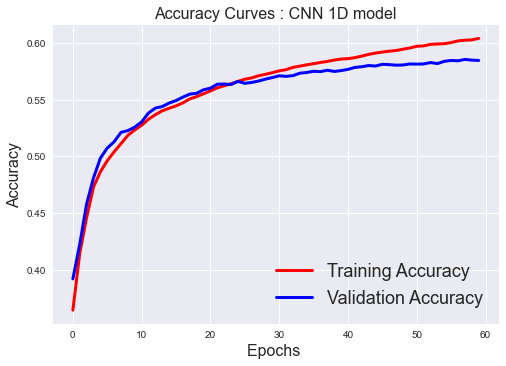

In [181]:
plot_loss_accuracy(cnn_history_model, 'CNN 1D model')

In [182]:
hist_4 = pd.DataFrame(cnn_history_model.history)
hist_4['epoch'] = cnn_history_model.epoch

In [202]:
hist_4.val_acc.max()

0.5854858756065369

In [184]:
_,val_acc = cnn_model.evaluate(val_dataset)

407/407 [==============================] - 9s 21ms/step - loss: 1.0020 - acc: 0.5846


### CNN model with drop-out

In [191]:

checkpointer_cnn_2 = ModelCheckpoint(filepath =check_point_cnn_2,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_cnn_2 = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [193]:
cnn_model_2 = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  Conv1D(128,3, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  
 
  
  Conv1D(128,5, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  Dropout(0.2),
  
  Conv1D(128,5, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  Dropout(0.2),
  
  Flatten(),
  Dense(128, activation = 'relu'),
  Dense(N_CLASSES, activation = softmax)
  ])

cnn_model_2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [196]:
cnn_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 100)          1000200   
                                                                 
 conv1d (Conv1D)             (None, 300, 128)          38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 128)          0

In [195]:
cnn_history_model_2 = cnn_model_2.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 20,
          callbacks=[checkpointer_cnn, early_stopping_cnn])

Epoch 1/20
3659/3659 [==============================] - ETA: 0s - loss: 1.3133 - acc: 0.3488

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 213s 58ms/step - loss: 1.3133 - acc: 0.3488 - val_loss: 1.2848 - val_acc: 0.3879
Epoch 2/20
3659/3659 [==============================] - ETA: 0s - loss: 1.2798 - acc: 0.3843

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 212s 58ms/step - loss: 1.2798 - acc: 0.3843 - val_loss: 1.2713 - val_acc: 0.4039
Epoch 3/20
3659/3659 [==============================] - ETA: 0s - loss: 1.2663 - acc: 0.4051

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 207s 56ms/step - loss: 1.2663 - acc: 0.4051 - val_loss: 1.2565 - val_acc: 0.4210
Epoch 4/20
3658/3659 [============================>.] - ETA: 0s - loss: 1.2516 - acc: 0.4236

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 202s 55ms/step - loss: 1.2515 - acc: 0.4237 - val_loss: 1.2349 - val_acc: 0.4448
Epoch 5/20
3658/3659 [============================>.] - ETA: 0s - loss: 1.2299 - acc: 0.4446

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 209s 57ms/step - loss: 1.2299 - acc: 0.4445 - val_loss: 1.2056 - val_acc: 0.4706
Epoch 6/20
3659/3659 [==============================] - ETA: 0s - loss: 1.2019 - acc: 0.4662

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 205s 56ms/step - loss: 1.2019 - acc: 0.4662 - val_loss: 1.1746 - val_acc: 0.4871
Epoch 7/20
3658/3659 [============================>.] - ETA: 0s - loss: 1.1764 - acc: 0.4798

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 202s 55ms/step - loss: 1.1764 - acc: 0.4797 - val_loss: 1.1499 - val_acc: 0.5008
Epoch 8/20
3659/3659 [==============================] - ETA: 0s - loss: 1.1550 - acc: 0.4886

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 205s 56ms/step - loss: 1.1550 - acc: 0.4886 - val_loss: 1.1307 - val_acc: 0.5100
Epoch 9/20
3659/3659 [==============================] - ETA: 0s - loss: 1.1396 - acc: 0.4971

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 192s 52ms/step - loss: 1.1396 - acc: 0.4971 - val_loss: 1.1167 - val_acc: 0.5180
Epoch 10/20
3659/3659 [==============================] - ETA: 0s - loss: 1.1259 - acc: 0.5031

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 205s 56ms/step - loss: 1.1259 - acc: 0.5031 - val_loss: 1.1058 - val_acc: 0.5228
Epoch 11/20
3658/3659 [============================>.] - ETA: 0s - loss: 1.1164 - acc: 0.5084

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 204s 56ms/step - loss: 1.1164 - acc: 0.5084 - val_loss: 1.0980 - val_acc: 0.5298
Epoch 12/20
3658/3659 [============================>.] - ETA: 0s - loss: 1.1076 - acc: 0.5126

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 215s 59ms/step - loss: 1.1077 - acc: 0.5126 - val_loss: 1.0914 - val_acc: 0.5324
Epoch 13/20
3659/3659 [==============================] - ETA: 0s - loss: 1.1013 - acc: 0.5157

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 208s 57ms/step - loss: 1.1013 - acc: 0.5157 - val_loss: 1.0858 - val_acc: 0.5318
Epoch 14/20
3659/3659 [==============================] - ETA: 0s - loss: 1.0963 - acc: 0.5200

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 209s 57ms/step - loss: 1.0963 - acc: 0.5200 - val_loss: 1.0810 - val_acc: 0.5360
Epoch 15/20
3659/3659 [==============================] - ETA: 0s - loss: 1.0903 - acc: 0.5228

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 202s 55ms/step - loss: 1.0903 - acc: 0.5228 - val_loss: 1.0774 - val_acc: 0.5387
Epoch 16/20
3658/3659 [============================>.] - ETA: 0s - loss: 1.0862 - acc: 0.5261

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 202s 55ms/step - loss: 1.0862 - acc: 0.5260 - val_loss: 1.0735 - val_acc: 0.5398
Epoch 17/20
3659/3659 [==============================] - ETA: 0s - loss: 1.0818 - acc: 0.5293

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 204s 56ms/step - loss: 1.0818 - acc: 0.5293 - val_loss: 1.0707 - val_acc: 0.5412
Epoch 18/20
3659/3659 [==============================] - ETA: 0s - loss: 1.0777 - acc: 0.5309

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 200s 55ms/step - loss: 1.0777 - acc: 0.5309 - val_loss: 1.0676 - val_acc: 0.5455
Epoch 19/20
3658/3659 [============================>.] - ETA: 0s - loss: 1.0735 - acc: 0.5341

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 207s 57ms/step - loss: 1.0735 - acc: 0.5341 - val_loss: 1.0644 - val_acc: 0.5480
Epoch 20/20
3659/3659 [==============================] - ETA: 0s - loss: 1.0709 - acc: 0.5354

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 2\checkpoint_cnn\assets


3659/3659 [==============================] - 207s 56ms/step - loss: 1.0709 - acc: 0.5354 - val_loss: 1.0619 - val_acc: 0.5487


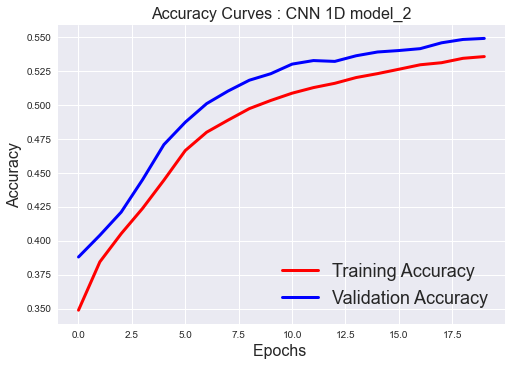

In [199]:
plot_loss_accuracy(cnn_history_model_2, 'CNN 1D model_2')

In [200]:
hist_5 = pd.DataFrame(cnn_history_model_2.history)
hist_5['epoch'] = cnn_history_model_2.epoch

In [201]:
_,val_acc = cnn_model_2.evaluate(val_dataset)

407/407 [==============================] - 9s 21ms/step - loss: 1.0619 - acc: 0.5487
